# Hard Drive Failure Prediction in the Data Center

## Stage 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pickle

#set matplotlib parameters
%matplotlib inline
sns.set_style('white')
plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

#### Import 1Q19 for initial data exploration.

In [2]:
cwd = os.getcwd()
df = pd.concat([pd.read_csv(f, header=0) for f in glob.glob(cwd + '/data/1Q19/*.csv')], ignore_index=True)
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2019-03-26,Z305B2QN,ST4000DM000,4000787030016,0,115.0,95758432.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-26,ZJV0XJQ4,ST12000NM0007,12000138625024,0,65.0,2934152.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-26,ZJV0XJQ3,ST12000NM0007,12000138625024,0,84.0,239925816.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-26,ZJV0XJQ0,ST12000NM0007,12000138625024,0,79.0,72393664.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-26,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# convert columns
df.capacity_bytes = df.capacity_bytes // 1000000000000 # convert bytes to terabytes
df.capacity_bytes = df.capacity_bytes.astype('str') + ' Tb'
df.capacity_bytes = df.capacity_bytes.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9577046 entries, 0 to 9577045
Columns: 129 entries, date to smart_255_raw
dtypes: category(1), float64(124), int64(1), object(3)
memory usage: 9.1+ GB


##### What brands and models are the most common in the Backblaze data center in 1Q19?

From the printout below, we can see that Seagate (ST) and Hitachi Global Storage Technologies (HGST) combined comprise ~97% of the total hard drives in the dataset.

In [4]:
num_drives = len(df.serial_number.unique()) # unique hard drives in 1Q19
print('{} unique hard drives in use in 1Q19.'.format(num_drives))
print('---------------------------------------------------------- \n')

print('Percentage of each model in the dataset. \n')
model_pcts = df.groupby('model').serial_number.nunique().sort_values(ascending=False) / num_drives * 100.0
print('{}%'.format(round(model_pcts, 2)))
print('---------------------------------------------------------- \n')

print('The top 10 models comprise {}% of the total.'.format(round(model_pcts.head(10).sum(), 2)))
print('---------------------------------------------------------- \n')

model_pcts = model_pcts.reset_index() # bring index of models into dataframe to fitler by model
ST = model_pcts[(model_pcts.model.str.startswith('ST'))].sum()[-1]
HGST = model_pcts[(model_pcts.model.str.startswith('HGST'))].sum()[-1]
print('ST and HGST models comprise: {}% of the total.'.format(round((ST + HGST), 2)))
print('---------------------------------------------------------- \n')
print('ST comprise: {}%'.format(round(ST/100 * 100, 2)))
print('HGST comprise: {}%'.format(round(HGST/100 * 100, 2)))   
print('Others comprise: {}%'.format(round((1 - ST/100 - HGST/100) * 100, 2)))

115231 unique hard drives in use in 1Q19.
---------------------------------------------------------- 

Percentage of each model in the dataset. 

model
ST12000NM0007                          30.29
ST4000DM000                            20.16
HGST HMS5C4040BLE640                   12.63
ST8000NM0055                           12.53
ST8000DM002                             8.60
HGST HUH721212ALN604                    4.23
HGST HMS5C4040ALE640                    4.16
ST6000DX000                             1.32
TOSHIBA MG07ACA14TA                     1.06
ST10000NM0086                           1.06
HGST HUH728080ALE600                    0.91
ST500LM012 HN                           0.53
TOSHIBA MQ01ABF050                      0.46
HGST HUH721212ALE600                    0.45
WDC WD60EFRX                            0.33
TOSHIBA MQ01ABF050M                     0.33
WDC WD5000LPVX                          0.24
ST500LM030                              0.18
TOSHIBA MD04ABA400V                   

##### How complete is the dataset, are there missing values (nan)?

From the printout below, we can see that a large percentage of some columns are missing values. In some cases the entire column is missing (e.g., smart_13 and smart_15).

In [5]:
for column in list(df):
    missing = round(df[column].notna().sum() / df.shape[0] * 100, 2)
    print('{:.<27}{}%'.format(column, missing))

date.......................100.0%
serial_number..............100.0%
model......................100.0%
capacity_bytes.............100.0%
failure....................100.0%
smart_1_normalized.........99.98%
smart_1_raw................99.98%
smart_2_normalized.........22.13%
smart_2_raw................22.13%
smart_3_normalized.........99.96%
smart_3_raw................99.96%
smart_4_normalized.........99.96%
smart_4_raw................99.96%
smart_5_normalized.........99.96%
smart_5_raw................99.96%
smart_7_normalized.........99.96%
smart_7_raw................99.96%
smart_8_normalized.........22.13%
smart_8_raw................22.13%
smart_9_normalized.........99.98%
smart_9_raw................99.98%
smart_10_normalized........99.96%
smart_10_raw...............99.96%
smart_11_normalized........1.14%
smart_11_raw...............1.14%
smart_12_normalized........99.98%
smart_12_raw...............99.98%
smart_13_normalized........0.0%
smart_13_raw...............0.0%
smart_15_normalized.

#### Filter by ST and HGST brands, and select the top 10 most common ST and HGST models.

-3.82% change in observations after filtering.
---------------------------------------------------------- 



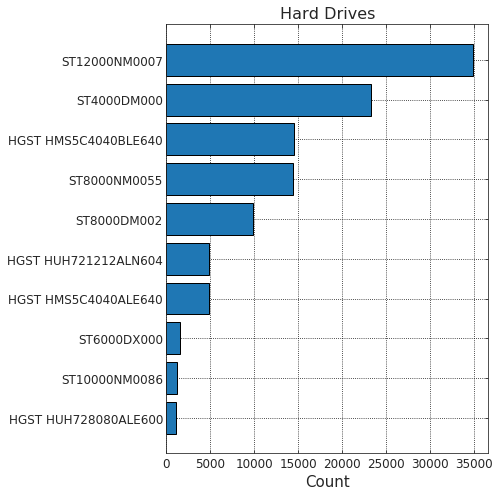

date.......................100.0%
serial_number..............100.0%
model......................100.0%
capacity_bytes.............100.0%
failure....................100.0%
smart_1_normalized.........99.99%
smart_1_raw................99.99%
smart_2_normalized.........19.96%
smart_2_raw................19.96%
smart_3_normalized.........99.99%
smart_3_raw................99.99%
smart_4_normalized.........99.99%
smart_4_raw................99.99%
smart_5_normalized.........99.99%
smart_5_raw................99.99%
smart_7_normalized.........99.99%
smart_7_raw................99.99%
smart_8_normalized.........19.96%
smart_8_raw................19.96%
smart_9_normalized.........99.99%
smart_9_raw................99.99%
smart_10_normalized........99.99%
smart_10_raw...............99.99%
smart_11_normalized........0.0%
smart_11_raw...............0.0%
smart_12_normalized........99.99%
smart_12_raw...............99.99%
smart_13_normalized........0.0%
smart_13_raw...............0.0%
smart_15_normalized...

In [6]:
n_rows_before = df.shape[0]

# filter by brands, and then select top ten ST and HGST models
brand_mask = (df['model'].str.startswith('ST')) | (df['model'].str.startswith('HGST')) # ST and HGST brands boolean mask
df = df[brand_mask]
model_mask = df.groupby('model').size().sort_values(ascending=False).head(10).index # find top ten models
model_mask = list(model_mask)
model_mask = df['model'].isin(model_mask) # build the boolean mask
df = df[model_mask]

# change in number of observations after filtering
n_rows_after = df.shape[0]
print('{}% change in observations after filtering.'.format(round((n_rows_after / n_rows_before - 1) * 100 , 2)))
print('---------------------------------------------------------- \n')

# plot counts of hard drives by model
fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(df.groupby('model').serial_number.nunique().sort_values().index, df.groupby('model').serial_number.nunique().sort_values(), edgecolor='k')
ax.set_xlabel('Count')
ax.set_title('Hard Drives', size=16)

plt.tight_layout()
plt.show()

for column in list(df):
    missing = round(df[column].notna().sum() / df.shape[0] * 100, 2)
    print('{:.<27}{}%'.format(column, missing))

#### Remove feature columns with more than 25% missing values.

In [7]:
pcts = df.notna().sum() / df.shape[0] * 100
cols = pcts < 75.0 # identify columns to remove True / False
cols = cols[list(cols)] # select column names with 'True' value
cols = cols[list(cols)].reset_index()
cols = list(cols['index']) # generate a list of column names to remove
df.drop(cols, axis=1, inplace=True) # drop columns

list(df)

['date',
 'serial_number',
 'model',
 'capacity_bytes',
 'failure',
 'smart_1_normalized',
 'smart_1_raw',
 'smart_3_normalized',
 'smart_3_raw',
 'smart_4_normalized',
 'smart_4_raw',
 'smart_5_normalized',
 'smart_5_raw',
 'smart_7_normalized',
 'smart_7_raw',
 'smart_9_normalized',
 'smart_9_raw',
 'smart_10_normalized',
 'smart_10_raw',
 'smart_12_normalized',
 'smart_12_raw',
 'smart_187_normalized',
 'smart_187_raw',
 'smart_188_normalized',
 'smart_188_raw',
 'smart_190_normalized',
 'smart_190_raw',
 'smart_192_normalized',
 'smart_192_raw',
 'smart_193_normalized',
 'smart_193_raw',
 'smart_194_normalized',
 'smart_194_raw',
 'smart_197_normalized',
 'smart_197_raw',
 'smart_198_normalized',
 'smart_198_raw',
 'smart_199_normalized',
 'smart_199_raw',
 'smart_240_normalized',
 'smart_240_raw',
 'smart_241_normalized',
 'smart_241_raw',
 'smart_242_normalized',
 'smart_242_raw']

##### What percent of hard drives in use failed in 1Q19?

In [8]:
num_fail = df.failure.sum() # number of drives failed in 1Q19
num_not_fail = len(df.serial_number.unique()) - num_fail
pct_fail = num_fail / (num_not_fail + num_fail) * 100 

print('{} failed in 1Q19'.format(num_fail))
print('{} did not fail in 1Q19'.format(num_not_fail))
print('{:5f}% failed'.format(pct_fail))

398 failed in 1Q19
110116 did not fail in 1Q19
0.360135% failed


##### What percent of hard drives failed, by model, in 1Q19?

If we count the number of hard drives by model, and calculate the percent of those that failed, we can see that model ST12000NM0007 had the highest percent of failures. This could be due to a variety of different reasons, for example, these hard drives may be the ones that get the heavist use, or they might be the oldest hard drives in the data center.

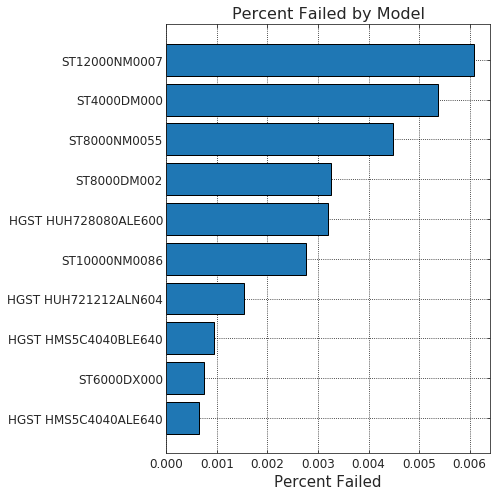

In [9]:
x1 = df[['model', 'failure']].groupby('model').sum() # number of failures by model
x2 = df[['model', 'failure']].groupby('model').count() # number of each model
pct_model_fail = np.divide(x1, x2) * 100 # element-wise division by model
pct_model_fail.columns = ['pct']
pct_model_fail = pct_model_fail.reset_index().sort_values('pct')

fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(pct_model_fail['model'], pct_model_fail['pct'], edgecolor='k')
ax.set_xlabel('Percent Failed')
ax.set_title('Percent Failed by Model', size=16)

plt.tight_layout()
plt.show()

##### How long have the hard drives been in service, by model, on average?

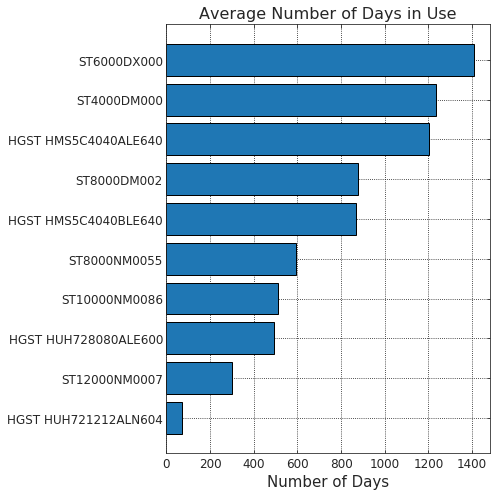

In [10]:
avg_days = df[['model', 'smart_9_raw']].groupby('model').mean() / 24.0
avg_days = avg_days.reset_index().sort_values('smart_9_raw')

fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(avg_days['model'], avg_days['smart_9_raw'], edgecolor='k')
ax.set_xlabel('Number of Days')
ax.set_title('Average Number of Days in Use', size=16)

plt.tight_layout()
plt.show()

#### Focus on the Seagate model ST4000DM000, since this model is consistently among the most likely to fail, the oldest, and the most common HDDs in the dataset.

In [11]:
df = df[df.model == 'ST4000DM000']
df.date = pd.to_datetime(df.date)

normalized = [col for col in list(df) if 'normalized' in col]
df = df.drop(columns=normalized, axis=1) # drop normalized columns since we are focusing on only one model
df = df.drop(columns='capacity_bytes', axis=1) # dealing with only one model...
df = df.sort_index()
df.describe()

,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,smart_187_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,1.989429e+06,1.989331e+06,1989331.0,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1989331.0,1.989331e+06,1.989331e+06,...,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06,1.989331e+06
mean,5.378428e-05,1.220387e+08,0.0,8.921708e+00,6.758382e+00,7.520257e+08,2.968890e+04,0.0,8.590011e+00,1.717718e-01,...,2.373366e+01,4.130866e-01,4.054121e+04,2.373366e+01,2.251722e-01,2.251722e-01,3.456680e-01,2.943243e+04,4.452547e+10,1.366264e+11
std,7.333581e-03,7.046885e+07,0.0,1.392315e+01,4.297687e+02,3.902230e+10,3.780251e+03,0.0,1.333532e+01,1.597371e+00,...,3.900969e+00,1.202896e+01,5.694469e+04,3.900969e+00,8.811193e+00,8.811193e+00,7.605052e+00,3.689477e+03,1.012233e+10,3.622120e+10
min,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,3.370000e+03,7.784000e+03,0.0,0.000000e+00,0.000000e+00,...,1.400000e+01,0.000000e+00,8.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.782000e+03,8.236652e+09,1.257659e+10
25%,0.000000e+00,6.098850e+07,0.0,5.000000e+00,0.000000e+00,2.721395e+08,2.723200e+04,0.0,5.000000e+00,0.000000e+00,...,2.100000e+01,0.000000e+00,7.943000e+03,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.700300e+04,4.178495e+10,1.183455e+11
50%,0.000000e+00,1.220651e+08,0.0,8.000000e+00,0.000000e+00,3.965901e+08,2.915800e+04,0.0,8.000000e+00,0.000000e+00,...,2.300000e+01,0.000000e+00,1.559000e+04,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+04,4.674401e+10,1.278074e+11
75%,0.000000e+00,1.829790e+08,0.0,1.100000e+01,0.000000e+00,5.448240e+08,3.194300e+04,0.0,1.100000e+01,0.000000e+00,...,2.600000e+01,0.000000e+00,4.888800e+04,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.155900e+04,5.103025e+10,1.396837e+11
max,1.000000e+00,2.441406e+08,0.0,1.290000e+03,5.228800e+04,7.297746e+12,4.973200e+04,0.0,1.232000e+03,1.070000e+02,...,5.000000e+01,1.117000e+03,6.629920e+05,5.000000e+01,6.536000e+03,6.536000e+03,6.010000e+02,4.960300e+04,7.004228e+10,7.684619e+11


In [12]:
df = df.drop(columns=['smart_3_raw', 'smart_10_raw'], axis=1) # drop columns with all zeros
columns_to_keep = list(df)

with open(cwd + '/data/columns_to_keep.pkl', 'wb') as file: # save column names to analyze in following stages
    pickle.dump(columns_to_keep, file)